# King County House Sales Analysis 

Here we will be looking into the King County House Sales dataset to find information on how home renovations might increase the estimated value of homes (and by what amount) for the magazine 'Home Owners Yearly', who wants put out an article on what renovations will most improve the value of homes.

In order to do this, we will be looking at a data set on houses and housing prices from [King County in Washington State](https://en.wikipedia.org/wiki/King_County,_Washington).

The dataset covers alot of information, so we will pick a few questions to focus on.

- Will adding bedrooms, bathrooms, or floors increase the value of the home?
- Will increasing the living area size up the value of the home?
    - (Is it important not to overbuild compared to your neighbors (increasing the size of your home so that it is much more than your neighbors)?)
- How important is the listed condition/grade of your home, and is it worth it to improve it?

In [1]:
# importing required packages
import warnings
import zipfile
import seaborn as sns
import sqlite3 as sql
import pandas as pd
import numpy as np
import copy
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
warnings.filterwarnings("ignore")

Describe the data sources and explain why the data are suitable for the project


## Looking at the dataset

In [2]:
# lets take an initial look at the data in the `kc_house_data.csv` dataset
df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# So above we see there are 21 columns, and it looks like 'price'
# may be a good contender for our dependant variable, as we 
# want to know what improvements will increase the selling price 
# of a home. 

In [4]:
#looking into the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
df.shape

(21597, 21)

So we see above that we have 21 columns, and 21,597 rows (each representing a different home) in total.


## Preprocessing 

### Check for missing values

In [7]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

 Lets peak into the three columns with NaN data, starting with the `waterfront` data: 

In [8]:
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Seems like we could recode these NaN's as NO - it could be that the NaN's are in areas where being on the waterfront isn't possible? Regardless, it's improbable that a homeowner or could change the location of a home to improve the homes value, but having a waterfront propety could affect the value of the renovations, so we'll replace all the NaN's with `NO`. 

In [9]:
df.waterfront.replace({np.nan: 'NO'}, inplace=True)
df['waterfront'].value_counts()
#df.head()

NO     21451
YES      146
Name: waterfront, dtype: int64

Now let's deal with the NaN's in `view`. Here we are not missing so many, so we could just drop those rows completely from the dataset, but let's peak into the data and see if we can convert the NaN's into another option instead. 


In [10]:
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

As we have the NONE value catagory (which makes up most of the data) we can just convert the NaN's into NONE's. 

In [11]:
df.view.replace({np.nan: 'NONE'}, inplace=True)
df['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Finally, lets look at `yr_renovated`. 

In [12]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

While we are looking at renovations, we are less interested in past renovations, and more concerned with future improvements we can do, but knowing when the last renovations were may still be usefull data. There already seems to be a missing data value (0.0) so we'll replace all our NaN's with that. 

In [13]:
df.yr_renovated.replace({np.nan: 0.0}, inplace=True)
df['yr_renovated'].value_counts()
#df.head()

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

### Dropping Columns 

When we looked into the NaN values, we saw that there are some columns that are irrelevant to the buisness question we are trying to answer. 

- (Just a reminder of the question: How could home renovations possibly increase the estimated value of homes?)

As such, we'll quickly peek into the `column_names.md.txt` file, to see what the column names mean and see if there are any more we can drop. 



Here's a copy-paste of the information in `column_names.md.txt`:

#### Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

- We should also probably drop `id` (as we don't need to know specific houses identifiers), `date` (as it's not important when the house was last sold), `lat`, `long`, and `zipcode` (as we can't change where the house is located). 

- The rest of the categories are things that could possibly be changed in the suggested renovations (e.g. you could add on another bedroom, which would change the value in `bedrooms`) or may have implications for the renovations (e.g. knowing when the house was built could affect the renovations.) 

- The `yr_renovated` and `yr_built` aren't directly related to our questions, and will likely add a lot of bulk/noise to our dataset. Additionally, we aren't asking questions about the lot sizes (or basement sizes), so lets drop `sqft_lot`, `sqft_above`, `sqft_basement`, and `sqft_15 too`.

Lets drop those variables now. 

In [14]:
df.drop(columns=['id', 'date', 'lat', 'long', 'zipcode'], axis= 1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1180,0.0,1955,0.0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,0.0,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,1800,7503


Great! Now our dataframe only includes variables that will (hopefully) allow us to answer our buisness question. Dealing with fewer variables will simplfy the analysis process. 

#### Limitations of Data

There are some limitations inherent to this dataset. First and formost, this dataset is all from King County, WA. This is a fairly affluent and densly populated area [(Wikipedia page)](https://en.wikipedia.org/wiki/King_County,_Washington), and as such the reccomendations and conclusions from this data may not hold true for other areas with different characteristics (e.g. rural areas). More information and analysis is neccessary to determine what neighborhoods and counties can use these recomendations. 

Additonally, there are many types of renovations that aren't included in the dataset (e.g. renovating the plumbing, new roof, adding a deck, ect.), which limits the specificity of the recomendations. 

### Handeling non-numeric values

Lets look into the types of data in our dataframe again, now that we've altered it a little. 

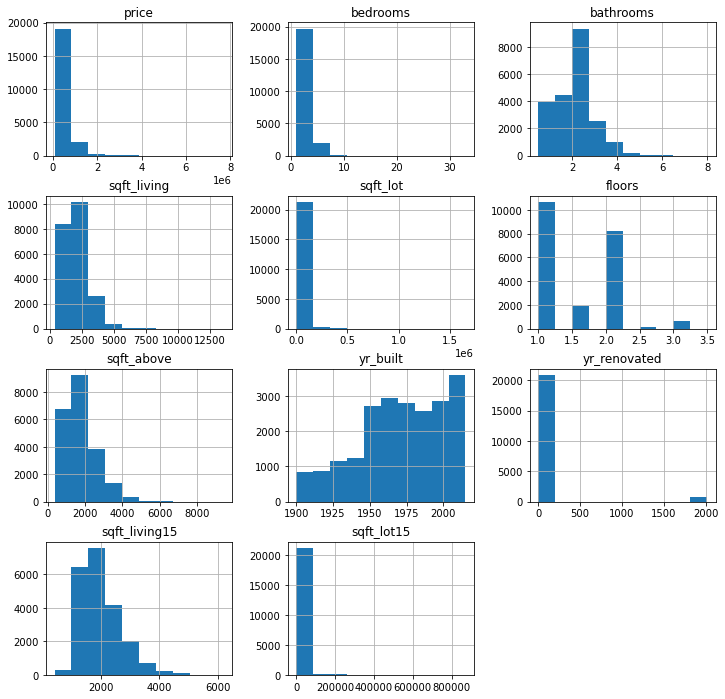

In [15]:
#look into columns
fig = plt.figure(figsize = (12, 12))
ax = fig.gca()
df.hist(ax = ax);

In [16]:
#looking into the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  object 
 7   view           21597 non-null  object 
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 2.6+ MB


We see we have 5 columns listed as objects - `waterfront`, `view`, `condition`, `grade`, and `sqft_basement`. 
- We've already looked into `waterfront` and seen that this catagory is binary - either `YES` or `NO`. As such, we can recode these as 1 and 0 respectivly. 
- We also already looked in `view`, so we can also recode these values on a scale of 0-4 (0 = `NONE`, ... 4 = `EXCELLENT`). 
- We'll have to look into `condition`, `grade`, and `sqft_basement` to better know how to handle them. 

Let's start by recoding `waterfront`: 

In [17]:
df['waterfront'] = df['waterfront'].replace(
    to_replace=['YES', 'NO'], 
    value=[1, 0])

In [18]:
#checking that the recode worked
df['waterfront'].value_counts()

0    21451
1      146
Name: waterfront, dtype: int64

Now we'll recode `view`:

In [19]:
df['view'] = df['view'].replace(
    to_replace=['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'], 
    value=[0, 1, 2, 3, 4])

In [20]:
#checking that the recode worked
df['view'].value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

Lets look into `condition`:

In [21]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

This is catagory is a little less intuitive to know how to classify, so I looked into the dictonary and went to the [link](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) mentioned there, searched for BUILDING CONDITION and found this scale to work with: 

1 = Poor, 2 = Fair, 3 = Average, 4 = Good, 5= Very Good

As such, we will recode the condition column as they reccomended!

In [22]:
df['condition'] = df['condition'].replace(
    to_replace=['Poor', 'Fair', 'Average', 'Good', 'Very Good'], 
    value=[1, 2, 3, 4, 5])

In [23]:
#check the changes we made
df['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

Looking into `grade`:

In [24]:
df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

So this is messier than the previous variables. Once again I looked in the `column_names.md.txt` dictionary and found this under the heading BUILDING GRADE: 

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

- 1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

- 4 Generally older, low quality construction. Does not meet code.

- 5 Low construction costs and workmanship. Small, simple design.

- 6 Lowest grade currently meeting building code. Low quality materials and simple designs.

- 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

- 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

- 9 Better architectural design with extra interior and exterior design and quality.

- 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

- 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

- 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

- 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc. 

From this we see that the values do have a scale, indicated by the numbers at the prefix of the values shown above, but the scale starts at 3 (as 1-3 seem to all be lumped into one catagory). As such, lets recode these values from 1 (Poor) to 11 (Mansion) according the the above scale. 

In [25]:
df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [26]:
df['grade'] = df['grade'].replace(
    to_replace=['3 Poor', '4 Low', '5 Fair', '6 Low Average',
                '7 Average', '8 Good', '9 Better', '10 Very Good', 
                '11 Excellent', '12 Luxury', '13 Mansion'], 
    value=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [27]:
#checking on the changes we made above
df['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

Finally, lets look at our last object catagory `sqft_basement`:

In [28]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2600.0        1
2610.0        1
2850.0        1
792.0         1
602.0         1
Name: sqft_basement, Length: 304, dtype: int64

So it seems like the only string variable that we have here is `?` - so lets turn all of those into zeros, and recast this catigory as a float. 

In [29]:
df['sqft_basement'] = df['sqft_basement'].replace(
    to_replace=['?'], 
    value=[0.0]).astype(float)

In [30]:
#Once again, checking what we did
df['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [31]:
# Now we see that there are no more `object` Dtypes - woohoo!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.6 MB


Now that we have all our data as integers or floats, we still have to deal with the categorical variables, otherwise when we try to build our models it will inteprete the information provided incorrectly. We will use one hot encoding (OHE) to do this. 

The columns we will use this on are as they are categorical are: `view`, `condition`, and  `grade`.

In [32]:
# OHE the above categories
cat_var = ['view', 'condition', 'grade']
preprocessed_df = pd.get_dummies(df, prefix=cat_var, columns=cat_var, drop_first=True)



In [33]:
#Look at the pretty preprocessed data!
preprocessed_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0.0,1955,...,0,0,0,1,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400.0,1951,...,0,0,0,1,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,770,0.0,1933,...,0,0,1,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910.0,1965,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0.0,1987,...,0,0,0,0,1,0,0,0,0,0


### Check for Multicollinearity 

In [34]:
#Now lets drop our dependant variable 'price' to look at 
#the relationships between our predictors
predict = preprocessed_df.drop('price', axis =1)
#and then we will look at the correlations between the predictors
corr_predictors = predict.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_predictors['pairs'] = list(zip(corr_predictors.level_0, corr_predictors.level_1))
corr_predictors.set_index(['pairs'], inplace=True)
corr_predictors.drop(columns=['level_1', 'level_0'], inplace = True)
corr_predictors.columns =['correlations']
corr_predictors[(corr_predictors.correlations>.75) & (corr_predictors.correlations < 1)]

,correlations
pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, sqft_above)",0.876448
"(condition_4, condition_3)",0.812294
"(condition_3, condition_4)",0.812294
"(sqft_living, sqft_living15)",0.756402
"(sqft_living15, sqft_living)",0.756402
"(sqft_living, bathrooms)",0.755758
"(bathrooms, sqft_living)",0.755758


For 3 out out of 4 of the above high correlations, we see that `sqft_living` is one of the variables, along with some of our OHE variables - `condition_3` and `condition_4`. For now, we will leave them in, but we'll try taking them out of our model later and see if that improves our results. 

(((Do some kind of feature engineering??))

In [35]:
preprocessed_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0.0,1955,...,0,0,0,1,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400.0,1951,...,0,0,0,1,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,770,0.0,1933,...,0,0,1,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910.0,1965,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0.0,1987,...,0,0,0,0,1,0,0,0,0,0


### Checking Variable Distributions

In [36]:
""" Just by looking at the `price` column, we see we have 
21,957 data points, with a mean sale price of 540,300$ (rounded
up)"""
preprocessed_df.describe()



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,1788.596842,285.716581,1970.999676,...,0.001250,0.011205,0.094365,0.415521,0.280826,0.121082,0.052507,0.018475,0.004121,0.000602
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,827.759761,439.819830,29.375234,...,0.035337,0.105263,0.292343,0.492823,0.449413,0.326230,0.223053,0.134664,0.064064,0.024528
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,370.000000,0.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,1190.000000,0.000000,1951.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,1560.000000,0.000000,1975.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,2210.000000,550.000000,1997.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,9410.000000,4820.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Basic Model

To start off we will pick an idependant variable that should be important (`sqft_living`) and create a simple linear model with our dependant variable `price` as our baseline model. (Remember, one of our initial questions was if increasing the living space of a home increased the homes value!)

After we've looked into this, we will add more variables to see if we can improve on the model. 

Before we start on this, lets check if the relationship between `price` and `sqft_living` meets the criteria for linear regression. 

Text(0.5, 1.0, 'Linearity and Homoscedasticity check')

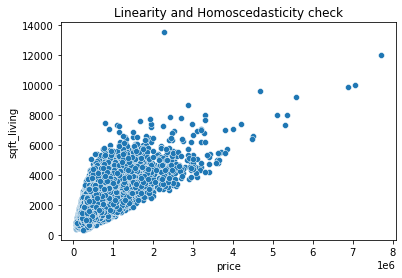

In [37]:
#check for linearity and Homoscedasticity
sns.scatterplot(x=preprocessed_df['price'], y=preprocessed_df['sqft_living'])
plt.title("Linearity and Homoscedasticity check")

In [38]:
# create predictors
predictors = preprocessed_df['sqft_living']
#create model intercept
predictors_int = sm.add_constant(predictors)
#fit model
model = sm.OLS(preprocessed_df['price'], predictors_int).fit()

#check model
model.params

const         -43988.892194
sqft_living      280.863014
dtype: float64

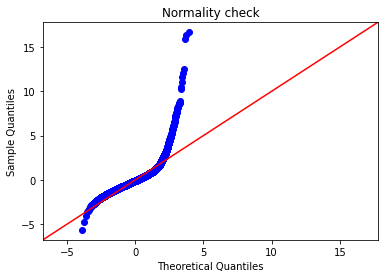

In [39]:
# check normality assumption

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Normality check")
fig.show()

So we see that 2/3 of the assumptions of linearity are violated here - the residuals aren't normally distributed, and the data isn't homoscedastic. We'll get a summary of the model as is, see if adding in some other variables to our model will improve R^2, and then see if performing a log transformation on `price` will help with these conditions. 

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:24:01   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Adding Features To Model 

### Bathrooms
Lets start by adding `bathrooms` to the model. 

First we'll check for linearity and homoscedasticity in `bathrooms`, `bedrooms`, `floors`, `grade` and `condition` compared to `price`.


In [50]:
#check for linearity and homoscedasticity
sns.scatterplot(x=preprocessed_df['price'], y=preprocessed_df[['bathrooms', 'bedrooms']])
#plt.title("Linearity and Homoscedasticity check")

ValueError: Shape of passed values is (2, 2), indices imply (21597, 2)

Once again, we see that there is linarity, but not homoscedasticity - lets check for normality 

In [41]:
# # apply logarithmic function to dependant variable
# log_price = np.log(preprocessed_df['price'])
# #re-create the model with `log_price`

# # create predictors
# predictors = preprocessed_df['sqft_living']
# #create model intercept
# predictors_int = sm.add_constant(predictors)
# #fit model
# model = sm.OLS(log_price, predictors_int).fit()

# #check model
# model.params


In [42]:
# residuals = model.resid
# fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
# plt.title("Normality check")
# fig.show()

Wohoo! It does look like perfoming a log function on the `price` helped with the normality assumption. Lets see if it helped with the homoscedasticity.

In [43]:
# # sns.scatterplot(x=log_price, y=preprocessed_df['sqft_living'])
# plt.title("Log Price Homoscedasticity check")

Not perfect, but much better. Lets look at our summary now.

In [44]:
# model.summary()

(((Next step - explore features relationships via scatterplot against price, building baseline model (sqft_living v. price), build second model including more features - all features added must have the linearity assumptions )))